In [1]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import datetime as dt
import glob
import os

In [2]:
# importing json files

dfs=[]
for file in glob.glob("data/*.json"):
    dataframe = pd.read_json(file)['posts']
    # flatten the structure
    dataframe = pd.json_normalize(dataframe)
    # insert file names
    dataframe['file_name'] = os.path.basename(file)
    dfs.append(dataframe)

# concatenate all data and drop repeated entries
df=pd.concat(dfs).drop_duplicates(subset='uuid', keep='last')

df.head()

,preview,is_locked,tweet_id,sticky_comment,removal_source,link,author_flair_class,is_video_mp4,is_removed,title,...,link_metadata.twitter.parentTweet.quotedTweet.video.url,link_metadata.twitter.parentTweet.linkEmbed.image,link_metadata.twitter.parentTweet.linkEmbed.domain,link_metadata.twitter.parentTweet.linkEmbed.description,link_metadata.twitter.parentTweet.linkEmbed.title,link_metadata.twitter.parentTweet.linkEmbed.url,link_metadata.twitter.poll.options,link_metadata.twitter.poll.votes,link_metadata.twitter.poll.endTime,link_metadata.twitter.poll.winningPercentage
1,https://media.patriots.win/preview/199OBBRLnB.png,False,,0,,https://justthenews.com/politics-policy/elections/harris-top-three-surrogates-clinton-obama-and-biden-backfire-campaign,,False,False,"Harris' top surrogates Clinton, Obama and Biden backfire on campaign trail, boosting Trump\n",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://media.patriots.win/preview/199OBBRcds.png,False,1846481206574973063,0,,https://twitter.com/LegitTargets/status/1846481206574973063,,False,False,"President Trump: ""China thinks we are a very stupid country.""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://media.patriots.win/preview/199OBBRuDq.png,False,,0,,https://rumble.com/v5htmr5-springfield-woman-accuses-haitian-neighbors-of-cooking-her-cat....html,,False,False,Springfield Woman Accuses Haitian Neighbors of Cooking Her CAT.\r\n\r\n\r\n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,https://media.patriots.win/preview/199OBBQWqP.png,False,,0,,https://media.scored.co/post/HuGmi3AXLuQz.png,,False,False,Times are tough for Tim Walz's friends under inflation.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,https://media.patriots.win/preview/199OBBRtpB.png,False,,0,,https://media.scored.co/post/kVoDIHDaM2Pn.jpeg,,False,False,"Greetings Patriots from Aruba! Miss all of you, just got internet, hope you are all holding down the Fort while I've been gone. 9 out of 10 people I've met are Trump Supporters, Amazing!!!",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# slicing out only relevant columns 

selected_columns = [
    'file_name',
    'uuid', 
    'title',
    'content',
    'post_flair_text',
    'author',
    'author_flair_text',
    'created',
    'comments',
    'score_up',
    'preview',
    'link',
    'domain',
    'is_image',
    'is_video',
    'video_link'
    ]	
df = df[selected_columns]

# Replace empty cell with Nan
dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)

# Format datetime
df['created'] = pd.to_datetime(df.created, unit='ms').dt.tz_localize('US/Eastern')
# crate a column storing "date" 
df['created_date'] = df['created'].dt.date
df['created_date'] = pd.to_datetime(df['created_date'])


# Fix empty or ill-formed domain column
selfpost_mask = df.domain.str.match('^$')
df.loc[selfpost_mask, 'domain'] = 'self_post'

df.created_date.value_counts().sort_index()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_2059/4060232883.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)


created_date
2024-07-21     31
2024-07-22    500
2024-07-23    615
2024-07-24    585
2024-07-25    631
             ... 
2024-10-18    625
2024-10-19    613
2024-10-20    641
2024-10-21    608
2024-10-22    243
Name: count, Length: 94, dtype: int64

In [4]:
# Unpack shortened domains
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import tldextract

common_shorts = [
    "adf.ly", "adfoc.us", "amzn.to", "atominik.com", "ay.gy", "b.link", "bhpho.to", "bit.ly", "bit.do", 
    "bn.gy", "branch.io", "buff.ly", "ceesty.com", "chollo.to", "cli.re", "cli.fm", "cutt.ly", "cutt.us", 
    "db.tt", "f.ls", "fa.by", "fb.me", "flip.it", "fumacrom.com", "git.io", "geni.us", "goo.gl", "gns.io", 
    "hmm.rs", "ht.ly", "hyperurl.co", "ity.im", "intamema.com", "is.gd", "j.gs", "j.mp", "kutt.it", "ldn.im", 
    "linklyhq.com", "microify.com", "mzl.la", "nmc.sg", "nowlinks.net", "ow.ly", "prf.hn", "plu.sh", "q.gs", 
    "qr.ae", "qr.net", "rebrand.ly", "rb.gy", "rlu.ru", "rotf.lol", "s.coop", "s.id", "sh.st", "soo.gd", 
    "shortcm.xyz", "short.gy", "shortcm.xyz", "shorturl.at", "smu.sg", "smq.tc", "snip.ly", "snipr.com", 
    "snipurl.com", "snurl.com", "split.to", "surl.li", "t.co", "t.ly", "t2m.io", "tiny.cc", "tiny.pl", 
    "tinyium.com", "tinyurl.com", "tiny.one", "tny.im", "tny.sh", "tr.im", "trib.al", "u.to", "v.gd", 
    "virg.in", "vzturl.com", "waa.ai", "washex.am", "x.co", "y2u.be", "yourwish.es", "zpr.io", "1url.com", 
    "2.gp", "3.ly", "4sq.com", "6url.com", "7.ly", "9.bb", "amp.gs", "atz.bz", "binged.it",
    "budurl.com", "cort.as", "decenturl.com", "dft.ba", "goo.gl", "inbound.org", "itsh.bo", "mcaf.ee",
    "n.pr", "nyti.ms", "on.fb.me", "prsm.tc", "redd.it", "tnw.to", "twt.fi", "u.nu", "virl.io", "wapo.st",
    "wp.me", "xrl.us",  "zurl.ws", "dlvr.it", 'msft.it', "lnkd.in ", 'spr.ly', 'rebelne.ws', 'scroll.in', 'ab.co',
    'hubs.li', 'bbc.in', 'nature.ly', 'cbsn.ws' , 'brnw.ch', 'youtu.be'
                ]

# Set up a Requests session with retries
session = requests.Session()
headers = {
    'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.5',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'DNT': '1',
    'referer': 'https://www.google.com/'
}

headers = {
        'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
        'referer':'https://google.com',
        'DNT':'1'
    }

# session.headers.update(headers)
retries = Retry(total=4, backoff_factor=1, status_forcelist=[502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))
session.mount('https://', HTTPAdapter(max_retries=retries))

def check_connection(host='http://www.google.com'):
    try:
        session.get(host, timeout=1)
        return True
    except (requests.ConnectionError, requests.Timeout):
        return False

def wait_for_connection(interval=30, max_attempts=10):
    attempts = 0
    while not check_connection() and attempts < max_attempts:
        time.sleep(interval)
        attempts += 1
    return attempts < max_attempts

def resolve_url_head(short_url):
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = requests.head(short_url, allow_redirects=True, timeout=1)
        return response.url if response.status_code == 200 else short_url
    except requests.RequestException:
        return short_url
    
def resolve_url_get(short_url):
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = session.get(short_url, allow_redirects=True, timeout=5)
        return response.url if response.status_code == 200 else short_url
    except requests.RequestException:
        return short_url
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = session.get(url=shortend_url, allow_redirects=True, timeout=1)        
   
    except requests.RequestException:
        return None    
    
df['domain'] = df['domain'].apply(lambda x: tldextract.extract(x).domain + "." + tldextract.extract(x).suffix if x != 'self_post' else 'self_post')
short_mask = df['domain'].isin(common_shorts)
df.loc[short_mask, 'domain'] = df.loc[short_mask, 'link'].apply(lambda x: resolve_url_get(x)).apply(lambda x: tldextract.extract(x).domain + "." + tldextract.extract(x).suffix)

In [5]:
# The top 10 most-shared domains on The Ronald's landing page
df.domain.value_counts(normalize=True).head(10)

domain
twitter.com             0.359277
scored.co               0.276376
patriots.win            0.143923
self_post               0.035298
thegatewaypundit.com    0.021151
youtube.com             0.018474
videy.co                0.010761
breitbart.com           0.009184
rumble.com              0.008616
zerohedge.com           0.007623
Name: proportion, dtype: float64

In [7]:
# Drop posts shared on  2024-07-21
df = df[df['created_date'] != '2024-07-21']

# Keep only the top 500 posts by "score_up" from each date so that the playing field is more leveled
df = df.groupby('created_date').apply(lambda x: x.nlargest(500, 'score_up')).reset_index(drop=True)

# check dates with less than 500 posts
post_date_count = df.groupby('created_date').size() < 500
post_date_count[post_date_count]

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_2059/1362746902.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('created_date').apply(lambda x: x.nlargest(500, 'score_up')).reset_index(drop=True)


created_date
2024-10-22    True
dtype: bool

In [8]:
# Extract twitter handles 
df[df.domain =='twitter.com'].link.str.split('/').str[3].str.lower()
df.loc[df.domain == 'twitter.com', 'twitter_handle'] = df[df.domain == 'twitter.com'].link.str.split('/').str[3].str.lower()
df['twitter_handle'].fillna(np.nan, inplace=True)

# Top 10 twitter handles
df.value_counts('twitter_handle', normalize=True, ascending=False).head(10)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_2059/3543245461.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['twitter_handle'].fillna(np.nan, inplace=True)


twitter_handle
elonmusk        0.035384
behizytweets    0.033337
endwokeness     0.026319
libsoftiktok    0.020002
trumpwarroom    0.018599
bennyjohnson    0.014154
nicksortor      0.011931
dc_draino       0.011463
collinrugg      0.011405
immeme0         0.011405
Name: proportion, dtype: float64

In [23]:
# Fix html markup in the title field

df.title = df.title.str.replace('\r', ' ').str.replace('\n', ' ')

In [24]:
# A function exporting a dataframe into an html table
def save_interactive_table(dataframe, save_filename):
    html_content = dataframe.to_html(render_links=True, 
                                         justify='center', 
                                         escape=False,
                                         classes='table table-striped table-hover', 
                                         table_id='my_table')
    with open(f'viz/{save_filename}.html', "w") as html_file:
         html_file.write(f"""
                <html>
                <head>
                <link rel="stylesheet" type="text/css" href="https://cdn.datatables.net/1.10.21/css/jquery.dataTables.css">
                <script type="text/javascript" charset="utf8" src="https://code.jquery.com/jquery-3.5.1.js"></script>
                <script type="text/javascript" charset="utf8" src="https://cdn.datatables.net/1.10.21/js/jquery.dataTables.js"></script>
                <script>
                $(document).ready( function () {{
                    $('#my_table').DataTable({{
                        pageLength: 25  // Set the number of entries to display per page
                    }});
                }} );
                </script>
                </head>
                <body>
                {html_content}
                </body>
                </html>
            """)
         
         return html_content

In [25]:
# A function that returns the top posts in interactive format
def top_posts_lastNdays(datafarme, num, Ndays, save_filename=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=Ndays)
    top_posts = datafarme[datafarme.created_date >= start_date].nlargest(num,'score_up')
    top_posts['post_link'] = "https://patriots.win/p/" + top_posts['uuid']
    top_posts['title'] = top_posts.apply(lambda row: f'<a href="{row["post_link"]}" target="_blank">{row["title"]}</a>', axis=1)
    top_posts = top_posts[['title', 
                           'score_up', 
                           'comments', 
                           'author'
                           ]]
    # rename column headers
    top_posts = top_posts.rename(columns={'title': 'post title',
                                         'score_up': 'upvote count',
                                         'comments' : 'comment count'})
    
    
    top_posts = top_posts.reset_index().drop(columns='index')
    top_posts.index = np.arange(1, len(top_posts)+1)
    
    if save_filename:
        save_interactive_table(top_posts, save_filename)
    
    return top_posts

In [35]:
datafarme = df
num = 10
Ndays = 1 
save_filename= 'top_10_posts_from_the_past_day'

top_posts_lastNdays(datafarme, num, Ndays, save_filename)

,post title,upvote count,comment count,author
1,"<a href=""https://patriots.win/p/199OKT7Ecq"" target=""_blank"">I am here tonight to deliver a simple message to Christians across America: It is time to stand up and SAVE YOUR COUNTRY. On November 5th, Christian voters need to turn out in the largest numbers ever!!!</a>",1799,74,Trump_Is_My_Daddy
2,"<a href=""https://patriots.win/p/199OKUDzJi"" target=""_blank"">Warden Admits Biden-Harris DOJ Has Illegally Imprisoned Steve Bannon Since October 19</a>",1410,89,I-am-Orlando
3,"<a href=""https://patriots.win/p/199OKUDAAe"" target=""_blank"">I voted for the new fry cook</a>",1382,31,grandmoff77
4,"<a href=""https://patriots.win/p/199OKUDAEo"" target=""_blank"">The best you’ll probably get from the MSM 🤷‍♂️ </a>",1370,146,MedicallyReddit
5,"<a href=""https://patriots.win/p/199OKT7F5i"" target=""_blank"">More. MORE.</a>",1366,158,AstroLonghorn
6,"<a href=""https://patriots.win/p/199OKUDz3A"" target=""_blank"">President Trump says that on July 13th he was knocked to the ground by a powerful supernatural hand. The Hand of God</a>",1291,105,I-am-Orlando
7,"<a href=""https://patriots.win/p/199OKUD9u6"" target=""_blank"">""We therefore demand that you immediately provide and publicly release the full, unedited transcript of the 60 Minutes Interview with Kamala Harris."" - Edward Andrew Paltzik, Counsel to President Donald J. Trump</a>",1192,49,no_comment
8,"<a href=""https://patriots.win/p/199OKUDz3G"" target=""_blank"">Media: Trump staged an event! — Also Media:</a>",1142,33,kompromatdotwin
9,"<a href=""https://patriots.win/p/199OKUDiP1"" target=""_blank"">Mark Cuban says he would be willing to work with the Trump administration if asked. “I’m America first.”</a>",1105,324,I-am-Orlando
10,"<a href=""https://patriots.win/p/199OKT7F9q"" target=""_blank"">Judges Reject RNC Lawsuits in Michigan and North Carolina on UOCAVA Ballots Allowing Overseas Voters to Cast Ballots in Michigan Despite Never Living There</a>",1068,64,TateDemarcus


In [27]:
import spacy
import nltk
nltk.download('wordnet')
from nltk import bigrams, trigrams
nlp = spacy.load('en_core_web_lg')
stopwords = list(nlp.Defaults.stop_words) 
stopwords.extend(["ago", 'old'])

import contractions
import emoji
import re



def clean_it_all_up (text, extra_stops):
    text = emoji.replace_emoji(text)
    text = contractions.fix(text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\n', ' ', text)
    doc = nlp(text)
    lemmatized_tokens = []
    
    for token in doc:
        if (
            token.text.lower() not in stopwords 
            and (extra_stops is None or token.text.lower() not in extra_stops) 
            # and token.pos_ in {'NOUN', 'PROPN', 'VERB', 'ADJ'} 
            # and token.ent_type_ not in {'GPE', 'LOC'}
            and token.pos_ not in {"AUX",
                                   "ADP",
                                   "CONJ", 
                                   "CCONJ", 
                                   "DET", 
                                   "INTJ", 
                                   "PART", 
                                   "PUNCT",
                                   "SCONJ", 
                                   "SYM", 
                                   "X", 
                                   "SPACE"}
        ):
          
            
            lemmatized_tokens.append(token.lemma_.lower())
            
    return " ".join(lemmatized_tokens)   


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/keenansmacbookairm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/keenansmacbookairm3/.pyenv/versions/3.12.0/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/keenansmacbookairm3/.pyenv/versions/3.12.0/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [28]:
def date_selection(start_date, end_date):
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    date_list = []
    current_date = start_date
    date_list.append(current_date.strftime('%Y-%m-%d'))

    while current_date < end_date:
        next_date = current_date + datetime.timedelta(days=1)
        next_date = next_date
        if next_date >= end_date:
            next_date = end_date
        date_list.append(next_date.strftime('%Y-%m-%d'))
        current_date = next_date

    return date_list


In [29]:
# Function of returning top ngrams between two given dates

def ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    
    date_list = date_selection(start_date, end_date)

    cleaned_tokens = ' '.join(dataframe[dataframe.created_date.isin(date_list)]['title'].apply(lambda x: clean_it_all_up(x, extra_stops)).tolist())

    if num == 1:
        ngram = pd.Series(cleaned_tokens.split()).value_counts()
    elif num == 2:
        ngram = pd.Series(list(bigrams(cleaned_tokens.split()))).value_counts()
    elif num == 3:
        ngram = pd.Series(list(trigrams(cleaned_tokens.split()))).value_counts()
    else:
        raise ValueError('Invalid number. Must choose between 1, 2, or 3.')
    
    ngram = ngram[ngram > 1].head(top_n)
    return ngram

In [36]:
# Function of returning top ngrams from the past 24 hours

def ngram_generator_24hrs(dataframe, num, extra_stops, top_n=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=1)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    
    return ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)

In [37]:
# run the ngram_generator_24hrs function 
dataframe = df
num = 2
top_n = 50
extra_stops=['trump']

top_50_bigrams_24hours = ngram_generator_24hrs(dataframe= dataframe, num=num, top_n=top_n, extra_stops=extra_stops )

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_2059/2909344436.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  cleaned_tokens = ' '.join(dataframe[dataframe.created_date.isin(date_list)]['title'].apply(lambda x: clean_it_all_up(x, extra_stops)).tolist())


In [38]:
# save the result in a new dataframe
top_50_bigrams_24hours_df = pd.DataFrame(top_50_bigrams_24hours).reset_index()

# adjust the index so that it starts at 1 instead of 0
top_50_bigrams_24hours_df.index = np.arange(1, len(top_50_bigrams_24hours_df)+1)

# rename column headers
top_50_bigrams_24hours_df.rename(columns={"index":'bigrams', 'count':'frequncy'}, inplace=True)

# create a top 50 bigrams table
dataframe= top_50_bigrams_24hours_df
save_filename= 'top_bigrams_24hrs_table'
save_interactive_table(dataframe, save_filename)


top_50_bigrams_24hours_df.head(10)

,bigrams,frequncy
1,"(kamala, harris)",25
2,"(mcdonald, s)",12
3,"(elon, musk)",9
4,"(election, night)",9
5,"(nathan, wade)",9
6,"(2, week)",8
7,"(work, mcdonald)",8
8,"(fani, willis)",8
9,"(voter, registration)",7
10,"(liz, cheney)",7


In [39]:
# A function to return a wordcloud chart covering a specific period of dates
from wordcloud import WordCloud

def ngram_cloud(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    ngram = ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='gist_stern').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

In [40]:
# A function returning a wordcloud chart covering ONLY the past 24 hours

def ngram_24hrs_cloud(dataframe, num, save_viz, extra_stops, set_title=False, top_n=None):
    ngram = ngram_generator_24hrs(dataframe, num, extra_stops, top_n)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, 
               interpolation='nearest',
               aspect="auto"
               )
    
    if set_title:
        plt.title(f"The chart was last updated on {datetime.datetime.now():%Y-%m-%d %H:%M} (UTC)",
                fontsize=20,
                pad=10,
                style= "italic",
                loc='center'
                )
    plt.axis('off')
    plt.tight_layout()

    if save_viz is not None:
        plt.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        plt.show()
    else:
        plt.show()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_2059/2909344436.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  cleaned_tokens = ' '.join(dataframe[dataframe.created_date.isin(date_list)]['title'].apply(lambda x: clean_it_all_up(x, extra_stops)).tolist())


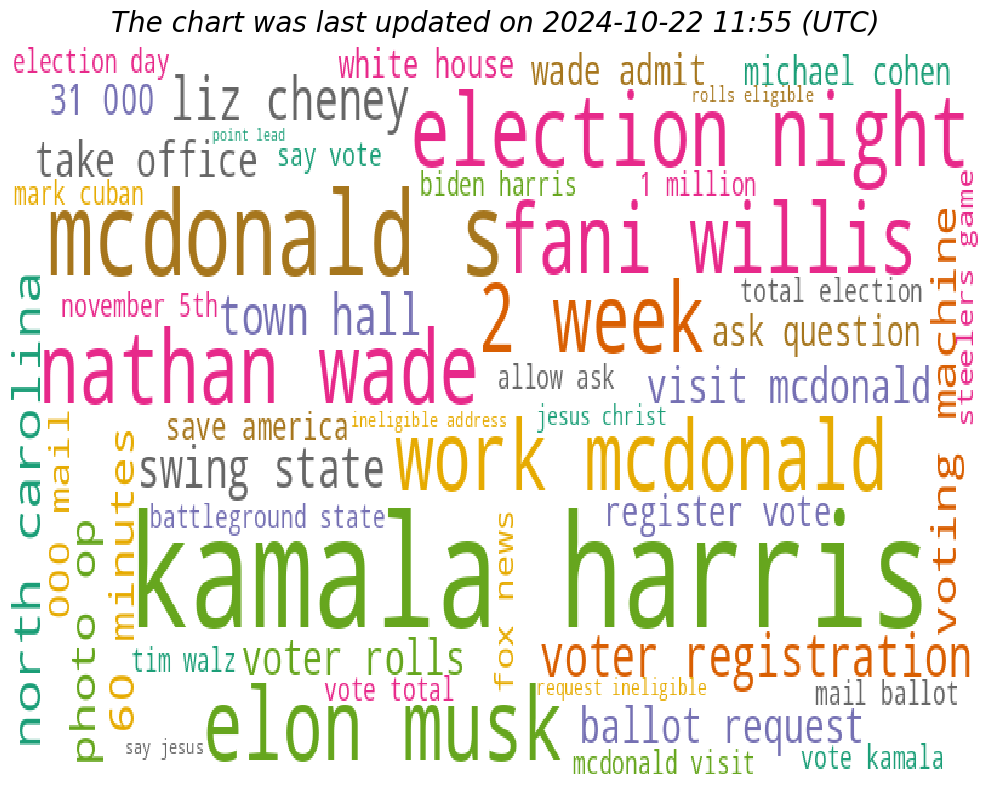

In [41]:
# creating and saving the top 50 bigrams from the last 24 hours
dataframe = df
num = 2
top_n = 50
save_viz = 'bigrams_wordcloud_24hrs'
extra_stops=['trump']
set_title=True

ngram_24hrs_cloud(dataframe = dataframe, num=num, top_n=top_n, save_viz=save_viz, set_title=set_title, extra_stops=extra_stops)

In [43]:
# create a separate dataframe that include only youtube-linked posts
youtube_df = df[df.domain=='youtube.com']
print(youtube_df.shape)

(716, 18)


In [32]:
# a functiont that extract youtube ids from urls
def youtube_parser(url):
    # Regular expression to capture YouTube video IDs from various URL formats
    id_pattern = r'(?:https?:\/\/)?(?:[0-9A-Z-]+\.)?(?:youtube|youtu|youtube-nocookie)\.(?:com|be)\/(?:watch\?v=|watch\?.+&v=|embed\/|v\/|.+\?v=)?([^&=\n%\?]{11})'
    
    match = re.search(id_pattern, url)
    return match.group(1) if match else np.nan

(716, 18)


/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_21586/3686488365.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youtube_df['youtube_id'] = youtube_df['link'].apply(youtube_parser)


In [ ]:
# extract videos id 
youtube_df['youtube_id'] = youtube_df['link'].apply(youtube_parser)

In [ ]:
# This function returns the most posted domains from the last nDays
def youtube_last_ndays(dataframe, nDays):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=nDays)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")

    date_list = date_selection(start_date, end_date)
    dataframe = dataframe[dataframe['created_date'].isin(date_list)].sort_values('score_up')
    return dataframe

In [34]:
youtube_3days_df = youtube_last_ndays(youtube_df, 3)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_21586/1971345704.py:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dataframe = dataframe[dataframe['created_date'].isin(date_list)].sort_values('score_up')


In [35]:
import os
from dotenv import load_dotenv

def congfiure():
    load_dotenv()
    api_key = os.getenv('api_key')
    return api_key

import sys
sys.path.append("/Users/keenansmacbookairm3/Documents/GitHub/SearchTube")
#importa
from SearchTube import tube_meta

In [36]:
video_id = youtube_3days_df.youtube_id.to_list()
api_key = congfiure()

video_meta =  tube_meta(video_id, api_key)
video_meta_df = pd.DataFrame(video_meta)

Video metadata list_1 fetched
---------
Finished fetching ALL 1 chunks of video metadata


In [37]:
# A funciton to extract first paragraph from a longer chunck of text
def find_first_paragraph(text):
    first_paragraph = re.search(r'(.+?)(?:\n\s*\n|$)', text, re.DOTALL)
    return first_paragraph.group(1).strip() if first_paragraph else ''

# run the function on the full description
video_meta_df['brief_desription'] = video_meta_df.full_description.apply(find_first_paragraph).str.replace('\n', ' ')

In [38]:
# merge the two youtube dataframes
youtube_3days_df = youtube_3days_df.merge(video_meta_df, left_on='youtube_id', right_on='video_id')

# rename publishedAt column and fix format
youtube_3days_df['publishedAt'] = pd.to_datetime(youtube_3days_df['publishedAt'])
youtube_3days_df['published_date_on_youtube']  = youtube_3days_df['publishedAt'].dt.date

In [39]:
# create a dataframe specifically for the html
display_df = youtube_3days_df[['full_title', 
                               'published_date_on_youtube',
                               'brief_desription', 
                               'channel_title', 
                               'link', 
                               'created_date',
                               'score_up',
                               'comments'
                               ]].sort_values('created_date', ascending=False)

# reset index 
display_df = display_df.reset_index(drop=True)
display_df.index +=1

# embed youtube to title text in the table
display_df['full_title']= display_df.apply(lambda row: f'<a href="{row["link"]}" target="_blank">{row["full_title"]}</a>', axis=1)

# drop link field
display_df = display_df.drop(columns = 'link')

# rename some column headers
display_df = display_df.rename(columns ={'full_title':'video title (Youtube)',
                                         'brief_desription': 'brief desription (Youtube)',
                                         'published_date_on_youtube': 'published date (Youtube)',
                                         'channel_title' : 'channel_title (Youtube)',
                                         "created_date": 'shared date (The Donald)',
                                         'score_up': 'upvote count (The Donald)',
                                         'comments' : 'comment count (The Donald)'
                                         })


In [61]:
# create a table for the top youtube videos and save it as "top_youtube_table"
top_youtube_table = save_interactive_table(display_df, save_filename=f"top_youtube_table")

In [41]:
# Looking into claims of election fraud
election_keywords = ['election', 'vote', 'voting', 'ballot', 'poll']
election_df = df[df.title.str.contains("|".join(election_keywords), case=False, na=False)]

fraud_keywords = ['fraud', 'cheat', 'rig', 'steal', 'stolen', 'fake','tamper', 'scam', 'interfer']
fraud_df = df[(df.title.str.contains("|".join(fraud_keywords) , case=False, na=False)) & (df.title.str.contains("|".join(election_keywords) , case=False, na=False))]

fraud_counts = fraud_df.created_date.value_counts(dropna=False).sort_index()
election_counts = election_df.created_date.value_counts(dropna=False).sort_index()

# merge two series into a dataframe
result_df = pd.DataFrame([fraud_counts, election_counts]).T

# rename the column headers
result_df.columns = ['election fraud', 'election']

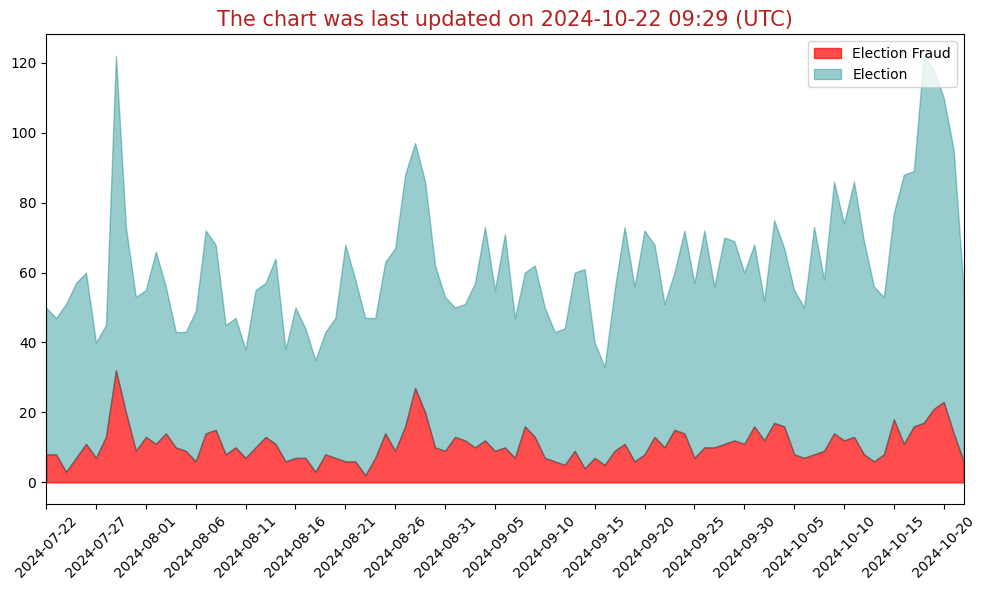

In [42]:
plt.figure(figsize=(10, 6))

plt.fill_between(result_df.index, result_df['election fraud'], color='red', alpha=0.7, label='Election Fraud')

plt.fill_between(result_df.index, 
                 result_df['election fraud'] + result_df['election'], 
                 result_df['election fraud'], 
                 color='teal', alpha=0.4, label='Election')

x_label_date_range = pd.date_range(fraud_df['created_date'].min(), 
                           fraud_df['created_date'].max(), 
                           freq='5D')


plt.xlim([fraud_df['created_date'].min(), fraud_df['created_date'].max()])

plt.xticks(ticks=x_label_date_range, 
           rotation=45)
plt.xlabel('')

# Updated title
election_fraud_tile = f"Posts mentioning election vs election fraud since 2022-07-22"

plt.legend(loc='upper right')
plt.title(label =f"The chart was last updated on {datetime.datetime.now():%Y-%m-%d %H:%M} (UTC)",
          fontdict = {"fontsize":15,
                      "color":'firebrick'
                      }
          )

plt.tight_layout()

# Save the figure
plt.savefig(f"viz/{election_fraud_tile}.jpeg", dpi=600)
plt.show()